In [18]:
import bottleneck as bn
import dask
import folium
import holoviews as hv
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pystac_client
import xarray as xr
import yaml
import zarr
import gc
import os
import rioxarray

import pandas as pd
from tqdm import tqdm
from ascat.read_native.ragged_array_ts import CellFileCollection
from collections import defaultdict
from dask.distributed import Client
from odc import stac as odc_stac
import odc.stac
from pathlib import Path
from pyproj import Transformer
from scipy.spatial import cKDTree
import warnings
from collections import defaultdict

import requests
! pip install geopandas
import geopandas as gpd

import tempfile
import zipfile
import io
from affine import Affine
from rasterio.features import rasterize
from datetime import timedelta


Looking in indexes: https://pypi.geo.tuwien.ac.at/simple, https://pypi.org/simple


In [ ]:
client = Client(processes=True,        # Each worker runs in a separate process - saver this way
                threads_per_worker=1,  # > 1 leads to multithreading issues
                n_workers=50,           # 25GB per worker
                memory_limit="500GB"   # we want to stay under 540GB
                )
client

/home/jwagner/miniconda3/envs/ascat-s1-synergy/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39671 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:39671/status,
Dashboard: http://127.0.0.1:39671/status,Workers: 20
Total threads: 20,Total memory: 9.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43141,Workers: 20
Dashboard: http://127.0.0.1:39671/status,Total threads: 20
Started: Just now,Total memory: 9.09 TiB
Comm: tcp://127.0.0.1:46183,Total threads: 1
Dashboard: http://127.0.0.1:42921/status,Memory: 465.66 GiB
Nanny: tcp://127.0.0.1:43237,


## Loading Sentinel - 1 Sigma Naught Data from EODC STAC Catalogue

In [20]:
eodc_catalog = pystac_client.Client.open("https://stac.eodc.eu/api/v1")

collection_id = "SENTINEL1_SIG0_20M"

collection = eodc_catalog.get_collection(collection_id)

### Area of Intesest

In [ ]:
# Area for testing the code (selected area so e.g. the ffill is visible)
"""
time_range ="2022-01-01/2022-03-01" 

latmin, latmax = 40, 41         # South to North
lonmin, lonmax = -6, -5           # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]
#"""

In [22]:
# Europe Africa Intersection
"""
time_range ="2022-01-01/2022-02-01"

latmin, latmax = 35, 37            # South to North
lonmin, lonmax = -6, -5           # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]
#"""

'\ntime_range ="2022-01-01/2022-02-01"\n\nlatmin, latmax = 35, 37            # South to North\nlonmin, lonmax = -6, -5           # West to East\n\nbounding_box = [lonmin, latmin, lonmax, latmax]\n#'

In [23]:
# Whole Spatial Area but...
"""
#time_range ="2022-01-06T18:28:01.000000000" # one image
time_range = "2022-01-06/2022-01-06"  # one month

latmin, latmax = 30.0, 45.0            # South to North
lonmin, lonmax = -10.0, 5.0            # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]
#"""

'\n#time_range ="2022-01-06T18:28:01.000000000" # one image\ntime_range = "2022-01-06/2022-01-06"  # one month\n\nlatmin, latmax = 30.0, 45.0            # South to North\nlonmin, lonmax = -10.0, 5.0            # West to East\n\nbounding_box = [lonmin, latmin, lonmax, latmax]\n#'

In [ ]:
# Area and Time of Interest
# This will not finish on your local pc
# Try to run in on a large Cluster
#"""
time_range = "2021-01-01/2023-12-31"

latmin, latmax = 30.0, 45.0            # South to North
lonmin, lonmax = -10.0, 5.0            # West to East

bounding_box = [lonmin, latmin, lonmax, latmax]

#"""

'\ntime_range = "2021-01-01/2023-12-31"\n\nlatmin, latmax = 30.0, 45.0            # South to North\nlonmin, lonmax = -10.0, 5.0            # West to East\n\nbounding_box = [lonmin, latmin, lonmax, latmax]\n\n#append to zar monthly ffill?\n#'

### Stack Request

In [25]:
search = eodc_catalog.search(
    collections=collection_id,
    bbox=bounding_box,
    datetime=time_range,
    #max_items=1  # number of max items to load
)
items_eodc = search.item_collection()
print(f"On EODC we found {len(items_eodc)} items for the given search query")

On EODC we found 213 items for the given search query


### Mapping Images to Tiles in Europe and Africa

Information on the Equi7 grid: https://cartography.tuwien.ac.at/eurocarto/wp-content/uploads/2015/09/3_6_ppt.pdf

In [26]:
# Split into European and African Equi7 projections

items_crs_europe = []
items_crs_africa = []

for item in items_eodc:
    wkt = item.properties["proj:wkt2"]
    lat_center = float(wkt.split('PARAMETER["latitude_of_center",')[1].split(']')[0])  # we select based on the latitude of the center of the projection

    if lat_center == 53.0:
        items_crs_europe.append(item)
    elif lat_center == 8.5:
        items_crs_africa.append(item)

print(f"Equi7 Europe (lat 53.0): {len(items_crs_europe)} items")
print(f"Equi7 Africa (lat 8.5): {len(items_crs_africa)} items")

Equi7 Europe (lat 53.0): 213 items
Equi7 Africa (lat 8.5): 0 items


In [27]:
# Make groups for each tile

def extract_tile_id_from_name(item_id):
    parts = item_id.split("_")
    tile_id = parts[3]
    if len(tile_id) == 10:
            return tile_id

european_tiles = defaultdict(list)
african_tiles = defaultdict(list)

for item in items_crs_europe:
    tile_id = extract_tile_id_from_name(item.id)
    if item not in european_tiles[tile_id]:
        european_tiles[tile_id].append(item)

for item in items_crs_africa:
    tile_id = extract_tile_id_from_name(item.id)
    if item not in african_tiles[tile_id]:
        african_tiles[tile_id].append(item)

print(f"European tiles: {len(european_tiles)}")
print(f"African tiles: {len(african_tiles)}")
european_tiles

European tiles: 2
African tiles: 0


defaultdict(list,
            {'E033N012T3': [<Item id=SIG0_20220301T063447_D052_E033N012T3_EU020M_V1M1R1_S1AIWGRDH>,
              <Item id=SIG0_20220301T063422_D052_E033N012T3_EU020M_V1M1R1_S1AIWGRDH>,
              <Item id=SIG0_20220301T063357_D052_E033N012T3_EU020M_V1M1R1_S1AIWGRDH>,
              <Item id=SIG0_20220225T181215_A001_E033N012T3_EU020M_V1M1R1_S1AIWGRDH>,
              <Item id=SIG0_20220225T181150_A001_E033N012T3_EU020M_V1M1R1_S1AIWGRDH>,
              <Item id=SIG0_20220225T181125_A001_E033N012T3_EU020M_V1M1R1_S1AIWGRDH>,
              <Item id=SIG0_20220224T062637_D154_E033N012T3_EU020M_V1M1R1_S1AIWGRDH>,
              <Item id=SIG0_20220224T062612_D154_E033N012T3_EU020M_V1M1R1_S1AIWGRDH>,
              <Item id=SIG0_20220224T062547_D154_E033N012T3_EU020M_V1M1R1_S1AIWGRDH>,
              <Item id=SIG0_20220223T182825_A147_E033N012T3_EU020M_V1M1R1_S1AIWGRDH>,
              <Item id=SIG0_20220223T182800_A147_E033N012T3_EU020M_V1M1R1_S1AIWGRDH>,
              <Item id

### Selecting the T3 files

As we do not want to load all the files we select the ones that are interesting for our analysis

<img src="..\images\Tiles_Europe.jpeg" alt="Tiles of Europe" width="400">
<img src="..\images\Tiles_Africa.jpeg" alt="Tiles of Europe" width="400">


In [28]:
# Selecting 14 European tiles
european_target_tiles = {
    "E027N009T3", 
    "E030N006T3", "E030N009T3", "E030N012T3", "E030N015T3", 
    "E033N006T3", "E033N009T3", "E033N012T3", "E033N015T3", 
    "E036N006T3", "E036N009T3", "E036N012T3",
    "E039N009T3", "E039N012T3" 
}

european_tiles = {
    tile_id: items
    for tile_id, items in european_tiles.items()
    if tile_id in european_target_tiles
}

# Selecting 6 African Tiles
african_target_tiles = {
    "E030N090T3", "E030N087T3",
    "E033N090T3", "E033N087T3", 
    "E036N090T3", "E036N087T3", 
}

african_tiles = {
    tile_id: items
    for tile_id, items in african_tiles.items()
    if tile_id in african_target_tiles
}

print(f"European tiles: {len(european_tiles)}")
print(f"African tiles: {len(african_tiles)}")

European tiles: 2
African tiles: 0


### Plothing Thumbnail of the data

In [29]:
# Showing thumbnail image of the data
"""
map = folium.Map(
    location=[(latmin + latmax) / 2, (lonmin + lonmax) / 2],
    zoom_start=7,
    zoom_control=True,
    scrollWheelZoom=False,
    dragging=False,
)

folium.Rectangle(
    bounds=[[latmin, lonmin], [latmax, lonmax]],
    color="blue",
    fill=True,
    fill_opacity=0.1,
    weight=2,
    popup="Area of Interest",
).add_to(map)

for item in african_tiles['E030N090T3']:
    # url leading to display of an item, can also be used as hyperlink
    image_url = item.assets["thumbnail"].href
    bounds = item.bbox
    folium.raster_layers.ImageOverlay(
        image=image_url,
        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
    ).add_to(map)

folium.LayerControl().add_to(map)

map
#"""

'\nmap = folium.Map(\n    location=[(latmin + latmax) / 2, (lonmin + lonmax) / 2],\n    zoom_start=7,\n    zoom_control=True,\n    scrollWheelZoom=False,\n    dragging=False,\n)\n\nfolium.Rectangle(\n    bounds=[[latmin, lonmin], [latmax, lonmax]],\n    color="blue",\n    fill=True,\n    fill_opacity=0.1,\n    weight=2,\n    popup="Area of Interest",\n).add_to(map)\n\nfor item in african_tiles[\'E030N090T3\']:\n    # url leading to display of an item, can also be used as hyperlink\n    image_url = item.assets["thumbnail"].href\n    bounds = item.bbox\n    folium.raster_layers.ImageOverlay(\n        image=image_url,\n        bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],\n    ).add_to(map)\n\nfolium.LayerControl().add_to(map)\n\nmap\n#'

### Loading Shapefiles

In [30]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

resp = requests.get(url)

with zipfile.ZipFile(io.BytesIO(resp.content)) as z:
    folder = "../data/Shapefiles/ne_110m_admin_0_countries"
    z.extractall(folder)

shp_path = os.path.join(folder, "ne_110m_admin_0_countries.shp")
gdf = gpd.read_file(shp_path)

mask_africa_df = gdf[gdf["CONTINENT"] == "Africa"]
mask_europe_df = gdf[gdf["CONTINENT"] == "Europe"]


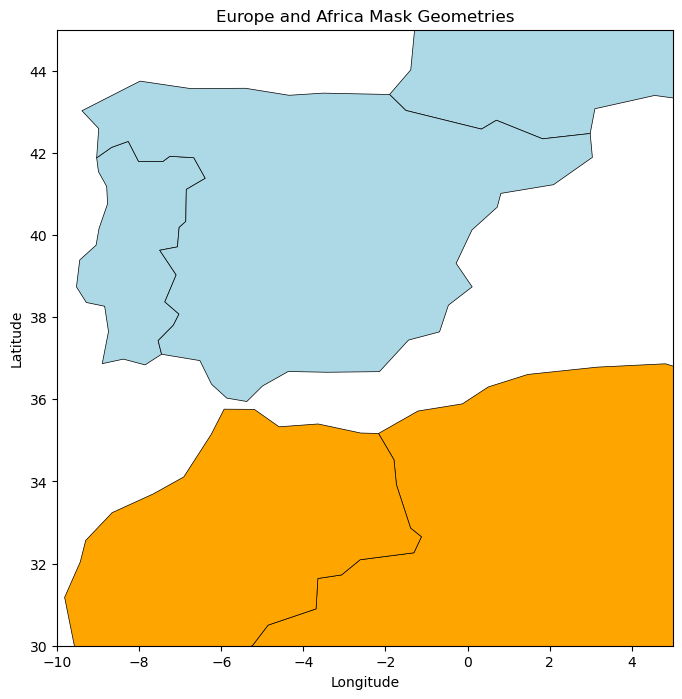

In [31]:
# visual check of area of interest
area = {
    "minx": -10.0,
    "maxx": 5,
    "miny": 30,
    "maxy": 45
}

fig, ax = plt.subplots(figsize=(10, 8))
mask_europe_df.plot(ax=ax, edgecolor="black", facecolor="lightblue", linewidth=0.5, label="Europe")
mask_africa_df.plot(ax=ax, edgecolor="black", facecolor="orange", linewidth=0.5, label="Africa")
ax.set_xlim(area["minx"], area["maxx"])
ax.set_ylim(area["miny"], area["maxy"])
plt.title("Europe and Africa Mask Geometries")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Run code tile-by-tile

In [32]:
def process_tile(tile_id, tiles_dict, crs, output_dir, mask_df, chunk_days=30):

    res = 20
    chunks = {"time": 1, "y": 15000, "x": 15000}
    try:

        tile_items = tiles_dict[tile_id]

        all_times = pd.to_datetime([item.datetime for item in tile_items])
        start_time = all_times.min()
        end_time = all_times.max()

        print(f"Processing tile {tile_id} from {start_time} to {end_time}")

        current = start_time
        while current <= end_time:
            next_time = current + timedelta(days=chunk_days)

            items_chunk = [
                item for item in tile_items 
                if current <= pd.Timestamp(item.datetime).ceil("1h") < next_time
            ] # filter items within the current time range

            if not items_chunk:
                current = next_time
                continue

            sig0_dc = odc.stac.load(
                items_chunk,
                crs=crs,
                resolution=res,
                chunks=chunks,
                fail_on_error=False # as on the project pc it had problems with empty items (e.g. SIG0_20220124T063537__VV_D052_E030N006T3)
            )                       # loading it localy this somehow works automatically - on Project PC fail_on_error is nesessary

            nodata = items_chunk[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
            scale = items_chunk[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

            sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale
            sig0_dc = sig0_dc.rio.clip(mask_df.geometry.values, mask_df.crs)

            # --- Processing ---
            linear = 10 ** (sig0_dc / 10)
            linear.coords["time"] = linear.time.dt.ceil("1h")
            hourly = linear.groupby("time").mean(skipna=True)
            coarse = hourly.coarsen(x=300, y=300, boundary="pad").mean()
            filled = coarse.ffill(dim="time")
            back_to_db = 10 * np.log10(filled)

            # --- Save or append ---
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, f"{tile_id}.zarr")

            if not os.path.exists(output_path):              # write
                back_to_db.to_zarr(output_path, mode="w")
            else:                                            # or append
                back_to_db.to_zarr(output_path, mode="a", append_dim="time")

            print(f"[{tile_id}] Appended {back_to_db.time.size} timesteps from {current.date()} to {next_time.date()}")

            # Clean up memory
            del sig0_dc, linear, hourly, coarse, filled, back_to_db
            gc.collect()

            current = next_time

    except Exception as e:
        print(f"Error processing tile {tile_id}: {e}")


## Processing European Tiles

In [33]:
for tile_id, items_list in tqdm(european_tiles.items(), desc="Processing European Tiles"):
    with dask.config.set(**{"array.slicing.split_large_chunks": False}):
        process_tile(
            tile_id=tile_id,
            tiles_dict=european_tiles,
            crs="EPSG:27704",  # Europe CRS
            output_dir="../data/Sentinel-1/Europe",
            mask_df=mask_europe_df
        )

Processing European Tiles:   0%|          | 0/2 [00:00<?, ?it/s]

Processing tile E033N012T3 from 2022-01-01 18:19:36+00:00 to 2022-03-01 06:34:47+00:00


/home/jwagner/miniconda3/envs/ascat-s1-synergy/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 214.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


[E033N012T3] Appended 22 timesteps from 2022-01-01 to 2022-01-31


/home/jwagner/miniconda3/envs/ascat-s1-synergy/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 214.65 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


[E033N012T3] Appended 17 timesteps from 2022-01-31 to 2022-03-02


Processing European Tiles:  50%|█████     | 1/2 [03:51<03:51, 231.38s/it]

Processing tile E033N009T3 from 2022-01-01 18:18:46+00:00 to 2022-03-01 06:34:47+00:00


/home/jwagner/miniconda3/envs/ascat-s1-synergy/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 214.66 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


[E033N009T3] Appended 21 timesteps from 2022-01-01 to 2022-01-31


/home/jwagner/miniconda3/envs/ascat-s1-synergy/lib/python3.10/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 214.65 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Ignoring read failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E033N009T3/SIG0_20220212T062702__VV_D154_E033N009T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif:1
Ignoring read failure while reading: https://data.eodc.eu/collections/SENTINEL1_SIG0_20M/V1M1R1/EQUI7_EU020M/E033N009T3/SIG0_20220206T181909__VV_A074_E033N009T3_EU020M_V1M1R1_S1AIWGRDH_TUWIEN.tif:1


[E033N009T3] Appended 19 timesteps from 2022-01-31 to 2022-03-02


Processing European Tiles: 100%|██████████| 2/2 [07:18<00:00, 219.11s/it]


## Processing African Tiles

In [ ]:
for tile_id, items_list in tqdm(african_tiles.items(), desc="Processing African Tiles"):
    with dask.config.set(**{"array.slicing.split_large_chunks": False}):
        process_tile(
            tile_id=tile_id,
            tiles_dict=african_tiles,
            crs="EPSG:27701",  # Africa CRS
            output_dir="../data/Sentinel-1/Africa",
            mask_df= mask_africa_df
        )

# Testing
Here tiles are manually loaded and the processing is tested: 

In [ ]:
#crs = "EPSG:27704" # Europe
crs = "EPSG:27701" # Africa

chunks = {"time": 1, "y": 15000, "x": 15000}
sig0_dc = odc_stac.load(
    #european_tiles['E036N006T3'],
    african_tiles['E030N090T3'],
    resolution=20, # errror if not set
    crs=crs,                                       
    chunks=chunks,
)

nodata = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["nodata"]
scale = items_eodc[0].assets["VV"].extra_fields["raster:bands"][0]["scale"]

sig0_dc = sig0_dc.where(sig0_dc != nodata) / scale

#sig0_dc = sig0_dc.rio.clip(mask_africa_df.geometry.values, mask_africa_df.crs)
#sig0_dc = sig0_dc.rio.clip(mask_europe_df.geometry.values, mask_europe_df.crs)

sig0_dc

## Processing

In [ ]:
# Transform to linear scale to do calculations 
sig0_dc_linear = 10 ** (sig0_dc / 10)

# Merge in time direction 
sig0_dc_linear.coords['time'] = sig0_dc_linear.time.dt.ceil('1h')
sig0_dc_linear_hourly = sig0_dc_linear.groupby('time').mean(skipna=True)

# Lower the resolution from 20m to 6km  
sig0_dc_linear_6km = sig0_dc_linear_hourly.coarsen(x=300, y=300, boundary='pad').mean() # 15000/300 = 50 pixels in x and y direction (for masked data this is smaller)

# ffill values 
sig_dc_linear_6km_filled = sig0_dc_linear_6km.ffill(dim="time")

# Convert back to dB
sig_dc_6km = 10 * np.log10(sig_dc_linear_6km_filled)

In [ ]:
sig_dc_6km.to_zarr("output_6km_filled.zarr", mode="w") 

In [ ]:
ax = plt.gca()
sig_dc_6km.isel(time=0).VV.plot.imshow()
ax.set_aspect('equal')
plt.show()

### Appending to Zarr

Here the problem is that all three dimmensions are not matching (at least one needs to):

- x
- y
- time

so we can not to the append to zarr. We will now try to load them all into a separate file and do the ASCAT-Sentinel merge for every tile instead.

In [ ]:
# x_vals = sig_dc_6km.coords["x"].values
# y_vals = sig_dc_6km.coords["y"].values

# x_min, x_max = x_vals.min(), x_vals.max()
# y_min, y_max = y_vals.min(), y_vals.max()
# print(f'"x": slice({x_min}, {x_max})')
# print(f'"y": slice({y_min}, {y_max})')

# append to zarr
# sig_dc_6km.to_zarr("output_6km_filled.zarr",mode="r+", region = {'x': slice(x_min, x_max), 'y': slice(y_min, y_max)})

### Plotting vor Verification
Some plotting to verify if the code produces the intended output

In [ ]:
# Show steps visually:
""" only run if in testing mode

sig0_dc_linear.VV.plot.imshow(col="time", col_wrap=3, robust=True)
plt.show()

sig0_dc_linear_hourly.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()

sig0_dc_linear_6km.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()

sig_dc_linear_6km_filled.VV.plot.imshow(col="time", col_wrap=2, robust=True)
plt.show()
#"""

In [ ]:
read_zarr = xr.open_zarr("../data/Sentinel-1/Europe/E033N009T3.zarr")
read_zarr

In [ ]:
read_zarr.VV.plot.imshow(col="time", col_wrap=4, robust=True)
plt.show()

In [ ]:
print(read_zarr.time.values)  # Check uniqueness and order
